<a href="https://colab.research.google.com/github/antonFJohansson/Bayesian-Learning-of-Neural-Network-Architectures/blob/master/NotebookVersion_n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

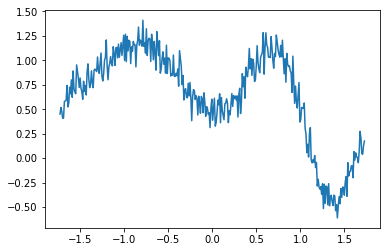

In [327]:
import torch
import numpy as np
x = np.arange(0,3.5,0.01)

y = np.sin(x) + 0.5*np.cos(x**2) + np.random.normal(0,0.1,x.shape)
x = (x - np.mean(x)) / np.std(x)
import matplotlib.pyplot as plt
x_t = torch.from_numpy(x).view(-1,1).float()
y_t = torch.from_numpy(y).view(-1,1).float()
plt.plot(x,y)

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 15 07:14:32 2019

@author: johaant
"""
import torch
import torch.nn as nn
import math

import numpy as np
from torch.distributions.normal import Normal
from numpy.random import logistic
import torch.nn.functional as F
from numpy import triu, ones

## For numerical stability
EPS_FACTOR = 1e-10


#torch.manual_seed(0)
#np.random.seed(0)

class BayesLinear(nn.Module):
  
  
  def __init__(self, h1, h2, bypass = True):
    super().__init__()
    self.bypass = bypass
    self.input_size = h1
    self.output_size = h2
    self.total_dim = h1*h2 ## If we see it as independent Gaussians then this is the full dimension of that distribution
    
    ## The init for the weight and bias parameters w.r.t the Normal dist
    mu_init_var = math.sqrt(2) * math.sqrt(2 / (h1 + h2))
    self.weight_mu = nn.Parameter(torch.Tensor(h1, h2).normal_(0, mu_init_var)) 
    self.weight_rho = nn.Parameter(torch.Tensor(h1, h2).uniform_(-5,-4))
    self.bias_mu = nn.Parameter(torch.Tensor(h2).normal_(0, 0.001))
    self.bias_rho = nn.Parameter(torch.Tensor(h2).uniform_(-5, -4))
    
    ## The init for the layer mean and variance 
    layer_mean = h2/2 if h2 != 1 else 1
    self.layer_mu = nn.Parameter(torch.Tensor(1).normal_(layer_mean, 10)) ## This one can be changed for different init for the layer mean. I had 0.5 as the variance
    self.layer_rho = nn.Parameter(torch.Tensor(1).uniform_(1, 10)) 
    
    ## The init if the layer has a bypass parameter
    if bypass:
      self.bypass_a = nn.Parameter(torch.Tensor(1).normal_(0,1))
      
     
    ## Some prior parameters under here
    self.tau = torch.tensor(1.) ## The temperature
    self.prior_weight_mu = torch.tensor(0.)
    self.prior_weight_sigma = torch.tensor(2.)
    
    self.prior_layer_mu = torch.tensor(h2/2) ## This one can be changed for different prior beliefs on the size of the network
    
    prior_var = (h2-1)/2 if h2 != 1 else 1.0
    self.prior_layer_sigma = torch.tensor(prior_var) 
    self.prior_layer_pi = self.layer_pi(self.prior_layer_mu, self.prior_layer_sigma)
    self.prior_bypass_pi = torch.tensor(0.5)
    
    ## The upper triangular matrix
    self.U = torch.from_numpy(triu(ones((h2, h2)))).float()
  
  def truncated_normal(self, x, mu, sigma):
    
    mu_n = mu.clone().detach() 
    sigma_n = sigma.clone().detach() 
    norm = Normal(mu_n, sigma_n)
    left_val = norm.cdf(1)
    right_val = norm.cdf(self.output_size)
    
    def log_normal(x, mu, sigma):
      return -1 / 2 * torch.log(2*math.pi*sigma**2 + EPS_FACTOR) - 1/ (2 * sigma**2 + EPS_FACTOR) * (x-mu)**2
    
    p1 = log_normal(x, mu, sigma)
    p2 = torch.log(right_val - left_val) if right_val != left_val else torch.tensor(0.)
    
    return torch.exp(p1-p2)
  
  ## The parameter pi for the layer bypass gumbal later. bypass_a should be inserted here
  def bypass_pi(self, x):
    return 1 / (1 + torch.exp(-x))
  
  ## Converts rho to sigma parameter
  def sigma(self, x):
    return torch.log1p(torch.exp(x))
  
  ## This one gives me the probability for the layer vector, later I also have to sample from Gumbal using this as pi
  def layer_pi(self, mu, sigma):
    input_x = torch.arange(1,self.output_size + 1).float()
    p1 = self.truncated_normal(input_x, mu, sigma)
    p2 = torch.sum(p1)
    return p1 / p2 
    
  ## s_p here is the sampled simplex vector
  def calc_layer_VI(self, s_p, post_lay_pi):
    ## Calc the prior term here first
    p1 = torch.log(torch.arange(1,self.output_size).float() + EPS_FACTOR).sum()
    p2 = (self.output_size - 1)*torch.log(self.tau)
    
    p3 = (torch.log(self.prior_layer_pi + EPS_FACTOR) - (self.tau + 1)*torch.log(s_p + EPS_FACTOR)).sum()
    p4 = self.output_size * torch.log((self.prior_layer_pi * torch.pow(s_p + EPS_FACTOR, -self.tau)).sum())
    log_prior = p1 + p2 + p3 - p4    
    
    ## And now calculate the variational posterior term. But I guess in the exact same way just with different parameters?
    p1 = torch.log(torch.arange(1,self.output_size).float() + EPS_FACTOR).sum()
    p2 = (self.output_size - 1)*torch.log(self.tau)
    p3 = (torch.log(post_lay_pi + EPS_FACTOR) - (self.tau + 1)*torch.log(s_p + EPS_FACTOR)).sum()
    p4 = self.output_size * torch.log((post_lay_pi * torch.pow(s_p + EPS_FACTOR, -self.tau)).sum() + EPS_FACTOR)
    log_post = p1 + p2 + p3 - p4
    return log_post - log_prior
  
  def calc_bypass_VI(self, s_p, post_bypass_pi):
    
    ## I am a little bit unsure if they have written it correctly in the article, should not 1-pi enter somewhere?
    ## First calculate the prior term
    p1 = torch.log(self.tau)
    p2 = torch.log(self.prior_bypass_pi + EPS_FACTOR) - (self.tau + 1) *(torch.log(s_p + EPS_FACTOR) + torch.log(1-s_p +EPS_FACTOR))
    p3 = 2*torch.log(self.prior_bypass_pi*torch.pow(s_p + EPS_FACTOR,-self.tau) + torch.pow((1-s_p + EPS_FACTOR),-self.tau) +EPS_FACTOR)
    log_prior = p1 + p2 - p3
    
    ## And now the variational posterior terms here
    p1 = torch.log(self.tau)
    p2 = torch.log(post_bypass_pi + EPS_FACTOR) - (self.tau + 1) *(torch.log(s_p + EPS_FACTOR) + torch.log(1-s_p + EPS_FACTOR))
    p3 = 2*torch.log(post_bypass_pi*torch.pow(s_p + EPS_FACTOR,-self.tau) + torch.pow((1-s_p),-self.tau) + EPS_FACTOR)
    log_post = p1 + p2 - p3
    return log_post - log_prior
  
  def calc_normal_KL(self, mu, sigma):
    
    p1 = 2*self.total_dim*torch.log(self.prior_weight_sigma + EPS_FACTOR)
    p2 = 2*torch.log(sigma + EPS_FACTOR).sum()
    p3 = self.total_dim
    p4 = (1 / self.prior_weight_sigma * sigma).sum()
    p5 = (1 / self.prior_weight_sigma * mu**2).sum()
    KL = 1 / 2 * (p1 - p2 - p3 + p4 + p5)
    return KL
    
  
    
  ## Should just return a sample of the concete categorical distribution
  def concrete_cat_sample(self, layer_pi):
    eps = -torch.log(-torch.log(torch.Tensor(self.output_size).uniform_(0,1) + EPS_FACTOR))
    
    ## Calc the sample here
    p1 = (torch.log(layer_pi + EPS_FACTOR) + eps) / self.tau
    p2 = torch.exp(p1)
    p3 = p2.sum()
    return p2 / p3
    
  def forward(self, x):
    if self.bypass:
      bypass_pi = self.bypass_pi(self.bypass_a)
      self.by_pi = bypass_pi 
      random_logistic = torch.tensor(logistic(0,1))
      gamma = 1 / (1 + torch.exp((-(torch.log(bypass_pi + EPS_FACTOR)-torch.log(1-bypass_pi + EPS_FACTOR) + random_logistic)/self.tau)))
    
    lay_mu = self.layer_mu
    lay_sig = self.sigma(self.layer_rho)
    lay_pi = self.layer_pi(lay_mu, lay_sig)
    self.lay_pi = lay_pi
    s_p = self.concrete_cat_sample(lay_pi)
    s_p = torch.unsqueeze(s_p,0)
    soft_mask = torch.mm(self.U, s_p.t()).t()
    
    w_mu = self.weight_mu
    w_sigma = self.sigma(self.weight_rho)
    weight = w_mu + w_sigma * torch.Tensor(w_mu.shape).normal_(0,1)
    
    b_mu = self.bias_mu
    b_sigma = self.sigma(self.bias_rho)
    bias = b_mu + b_sigma * torch.Tensor(b_mu.shape).normal_(0,1)
    
    ## I don't have any bias term for the layer and bypass, they only affect the regular neurons
    self.layer_VI = self.calc_layer_VI(s_p, lay_pi)
    self.weight_VI = self.calc_normal_KL(w_mu, w_sigma)
    self.bias_VI = self.calc_normal_KL(b_mu, b_sigma)
    if self.bypass:
      self.bypass_VI = self.calc_bypass_VI(gamma, bypass_pi).item()
    
    if self.bypass:
      
      return (1-gamma)*F.linear(x, torch.t(weight), bias) * soft_mask + gamma * x
    else:
      
      return F.linear(x, torch.t(weight), bias) * soft_mask
    
    


In [0]:

    
    
from torch import autograd

class Network(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.fc1 = BayesLinear(1, 50, False)
    self.fc2 = BayesLinear(50, 50, True)
    self.fc3 = BayesLinear(50, 50, True)
    self.fc4 = BayesLinear(50, 50, True)
    self.fc5 = BayesLinear(50, 50, True)
    self.fc6 = BayesLinear(50, 50, True)
    self.fc7 = BayesLinear(50, 1, False)
    self.loss_fn = nn.MSELoss(reduction = 'sum')
    self.layer_list = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.fc6, self.fc7]
    
  def calc_VI(self):
      
    VI_tot = 0
    for layer in self.layer_list:
        VI_tot = VI_tot + layer.weight_VI + layer.bias_VI + layer.layer_VI
        if layer.bypass:
            VI_tot = VI_tot + layer.bypass_VI
    
    return VI_tot
  
  def calc_loss(self, x, y, num_train_samples = 1):
    
    loss1_store = torch.zeros((1, num_train_samples))
    loss2_store = torch.zeros((1, num_train_samples))
    
    for rrr in range(num_train_samples):

      out = self.forward(x)
      loss = self.loss_fn(out, y)
      loss1_store[0, rrr] = loss
      loss2_store[0, rrr] = self.calc_VI()
      
      final_loss1 = torch.mean(loss1_store)
      final_loss2 = torch.mean(loss2_store)
    return final_loss1, final_loss2
  
  
  def forward(self, x):
      
    for layer in self.layer_list[:-1]:
        x = F.relu(layer(x))
    x = self.layer_list[-1](x)

    return x



In [340]:

import torch.optim as optim
my_net = Network()



max_epoch = 5000
opt = optim.Adam(my_net.parameters(), lr = 0.001)

weight_step = 0.0
weight_factor = torch.exp(torch.tensor(weight_step))

#with autograd.detect_anomaly():
for epoch in range(max_epoch):
      
      
      my_net.zero_grad()
      loss1, loss2 = my_net.calc_loss(x_t, y_t)
      total_loss = loss1 + loss2 * weight_factor
      total_loss.backward()
      opt.step()
      if epoch % (max_epoch // 10) == 0:
        print('Epoch {} Likelihood Loss {:.2f} Prior Loss {:.2f}'.format(epoch, loss1, loss2))      
        weight_step = weight_step + 0.5
        weight_factor = torch.exp(-torch.tensor(weight_step))



Epoch 0 Likelihood Loss 189.90 Prior Loss 65014.98
Epoch 500 Likelihood Loss 31.42 Prior Loss 58269.40
Epoch 1000 Likelihood Loss 9.66 Prior Loss 53576.15
Epoch 1500 Likelihood Loss 28.11 Prior Loss 50098.84
Epoch 2000 Likelihood Loss 9.43 Prior Loss 47548.94
Epoch 2500 Likelihood Loss 15.47 Prior Loss 45450.49
Epoch 3000 Likelihood Loss 9.60 Prior Loss 43833.86
Epoch 3500 Likelihood Loss 11.55 Prior Loss 42673.57
Epoch 4000 Likelihood Loss 19.38 Prior Loss 41666.94
Epoch 4500 Likelihood Loss 7.14 Prior Loss 41119.65


[-5, 5, -2, 2]

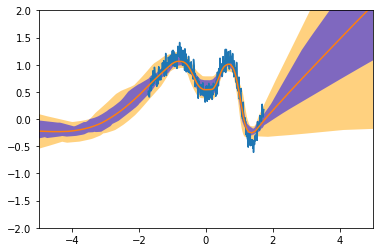

In [341]:

plt.plot(x,y)
left_plot_lim = -5
right_plot_lim = 5
x_plot = np.arange(left_plot_lim, right_plot_lim,0.001)
x_plot_n = torch.from_numpy(x_plot).float().view(-1,1)

SAMPLES = 15
out_plot_store = torch.zeros((x_plot_n.shape[0], SAMPLES))
for iii in range(SAMPLES):
  
  out_plot = my_net(x_plot_n)
  out_plot_store[:,iii] = out_plot[:,0]

  
sorted_val = torch.sort(out_plot_store)
upper_ind = int(0.8*SAMPLES)
lower_ind = int(0.2*SAMPLES)

q80 = sorted_val[0][:, upper_ind].detach().numpy()
q20 = sorted_val[0][:, lower_ind].detach().numpy()
  
max_plot = torch.max(out_plot_store, 1)
min_plot = torch.min(out_plot_store, 1)
mean_plot = torch.mean(out_plot_store, 1)
lb = min_plot[0].detach().numpy()
ub = max_plot[0].detach().numpy()

plt.plot(x_plot, mean_plot.detach().numpy())
plt.fill_between(x_plot, lb, ub, facecolor='orange', alpha=0.5)
plt.fill_between(x_plot, q20, q80, facecolor='blue', alpha=0.5)
plt.axis([left_plot_lim, right_plot_lim, -2, 2])              


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0.25571072]')

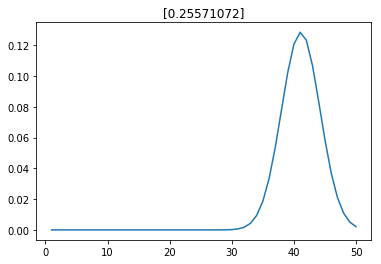

In [344]:
import numpy as np
lay_pi_val = my_net.fc2.lay_pi.detach().numpy()
lay_plot = np.arange(1,lay_pi_val.shape[0] + 1)
lay_plot.shape
plt.plot(lay_plot, lay_pi_val)
#plt.violinplot(lay_pi_val)
plt.title(my_net.fc2.by_pi.detach().numpy())